In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools

C:\Users\ChungWa\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# custom module
import pair_selector

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Load Data

In [3]:
dateparser = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

data = {}
data["raw"] = pd.read_csv("../sample-data/hsi-top-30.csv", parse_dates=['DateTime'], date_parser=dateparser , index_col='DateTime')

In [4]:
stock_names = data["raw"].columns.values.tolist()

In [5]:
data["raw"].index

DatetimeIndex(['2013-09-09', '2013-09-10', '2013-09-11', '2013-09-12',
               '2013-09-13', '2013-09-16', '2013-09-17', '2013-09-18',
               '2013-09-19', '2013-09-20',
               ...
               '2018-08-27', '2018-08-28', '2018-08-29', '2018-08-30',
               '2018-08-31', '2018-09-03', '2018-09-04', '2018-09-05',
               '2018-09-06', '2018-09-07'],
              dtype='datetime64[ns]', name='DateTime', length=1305, freq=None)

In [6]:
invalid_stocks = []

for stock in stock_names:
    index_with_negatives = data["raw"].index[data["raw"][stock] < 0]
    
    if len(index_with_negatives) > 0:
        invalid_stocks.append(stock)

invalid_stocks

['1113 HK Equity']

In [7]:
valid_stocks = [x for x in stock_names if x not in invalid_stocks]

data["valid_stocks"] = data["raw"][valid_stocks]

In [8]:
traning_size = 252
testing_size = 252
train_df = data["valid_stocks"].iloc[-traning_size-testing_size:-testing_size]
test_df = data["valid_stocks"].iloc[-testing_size:]

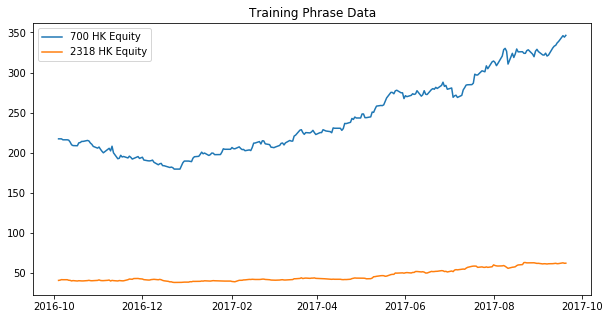

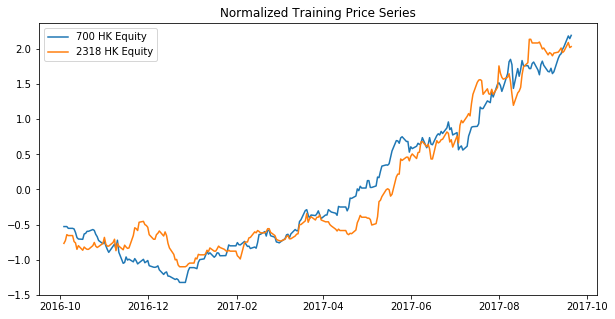

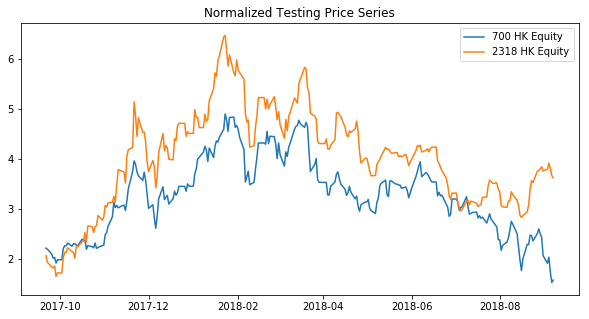

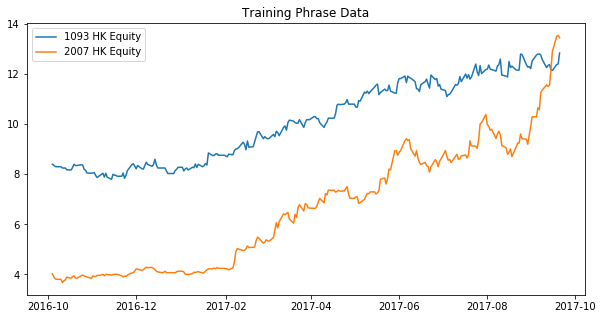

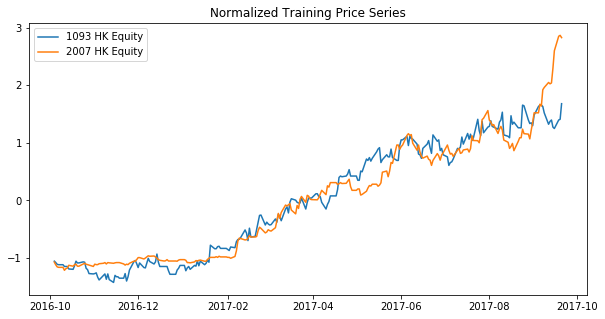

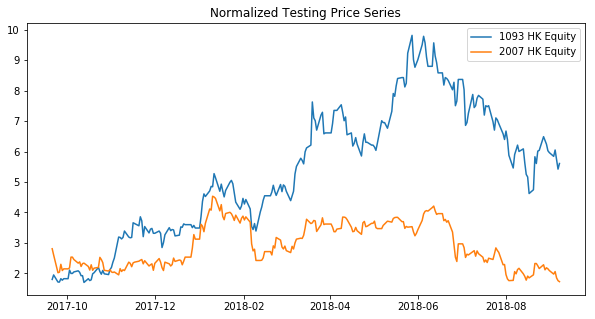

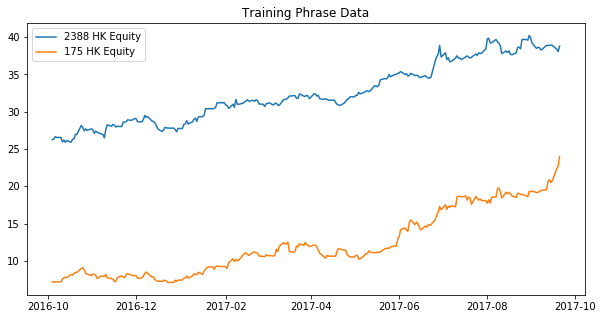

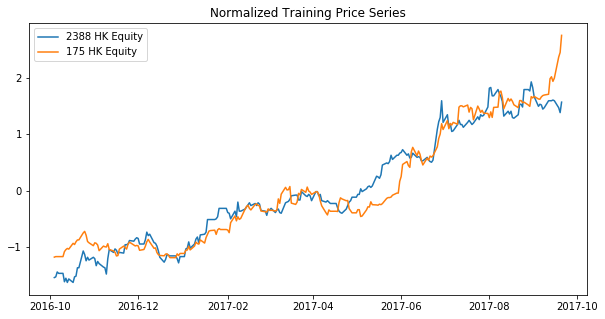

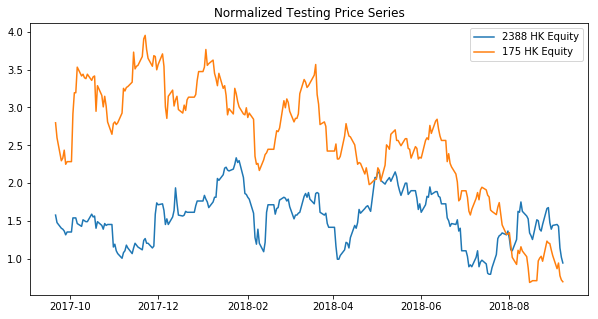

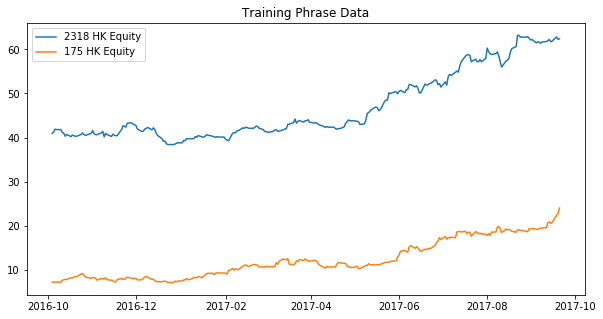

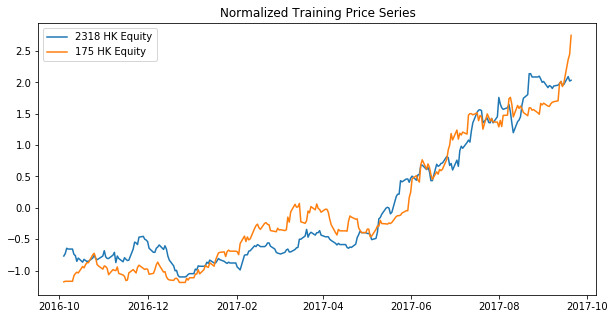

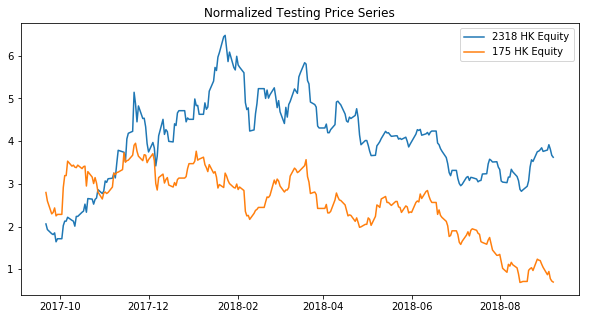

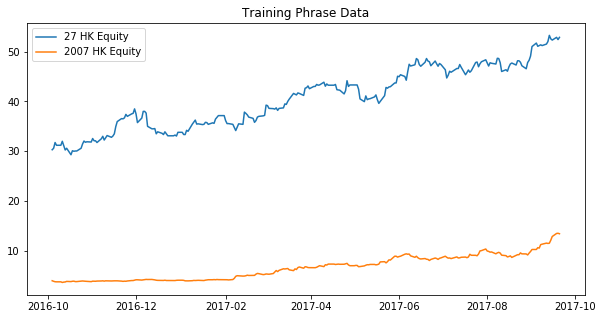

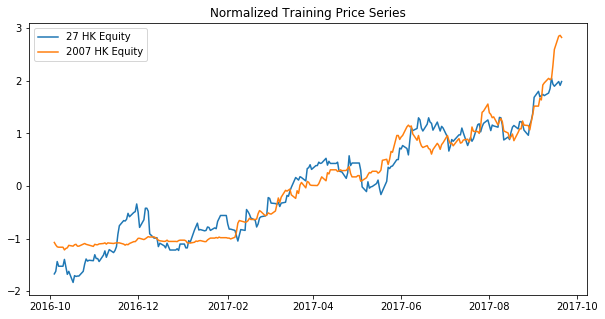

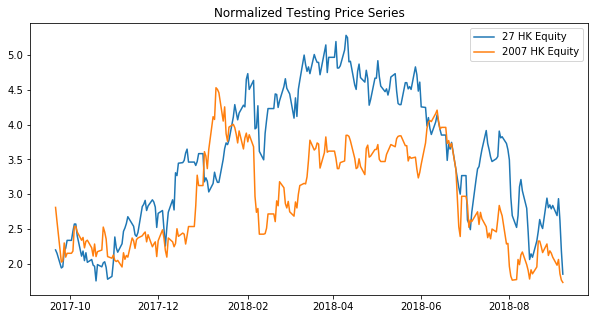

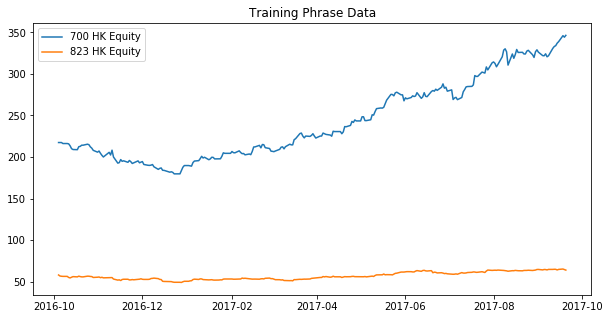

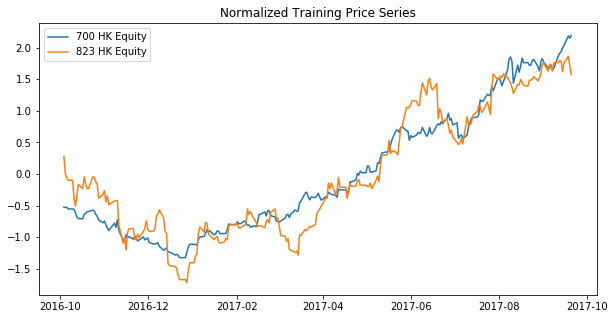

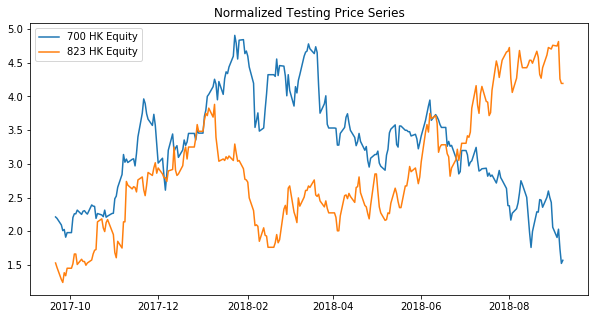

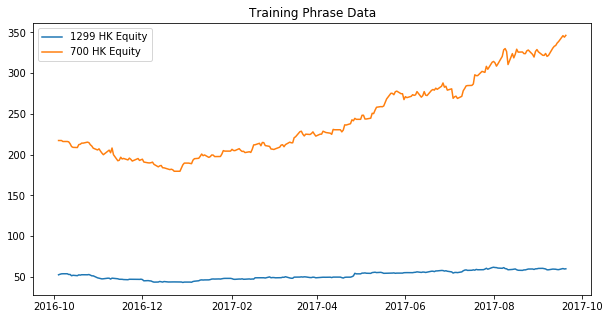

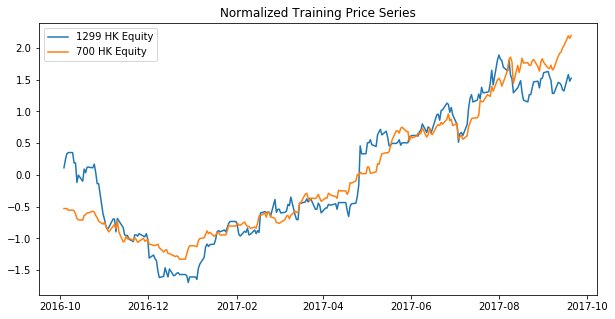

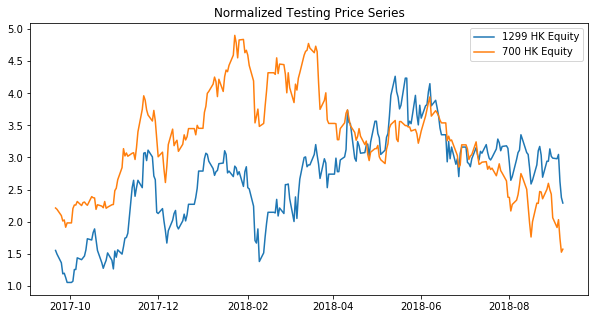

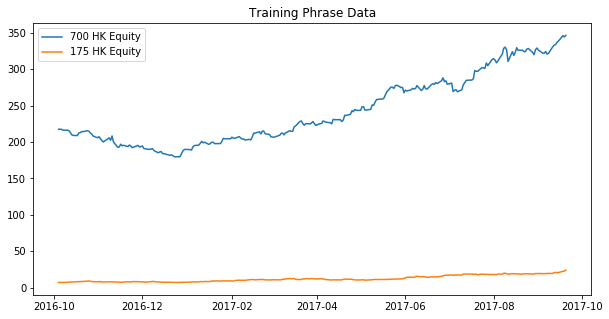

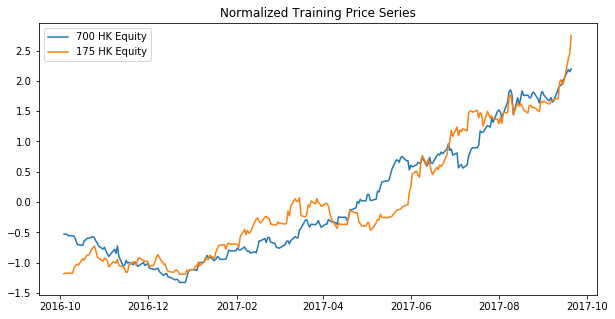

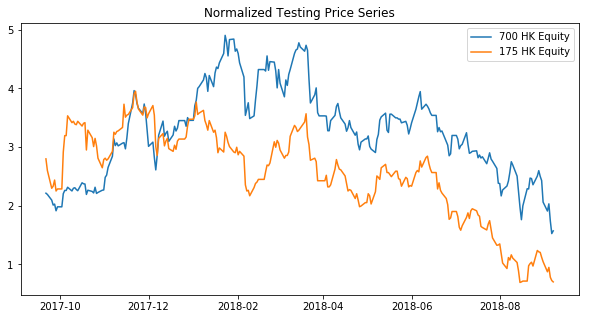

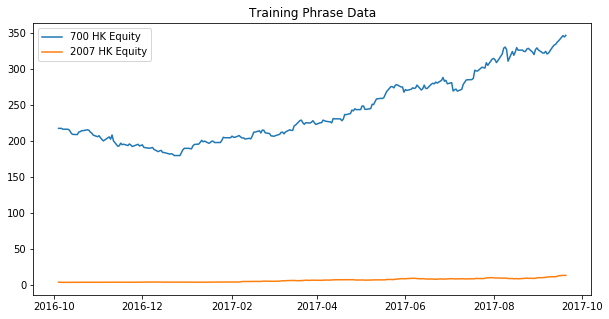

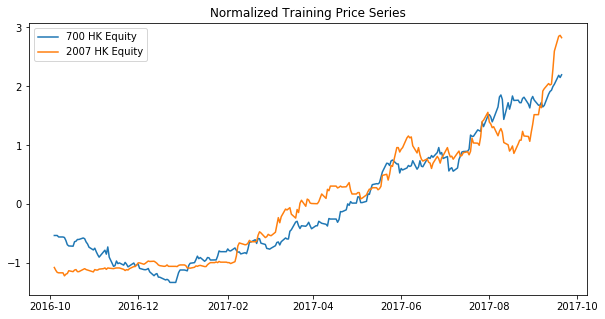

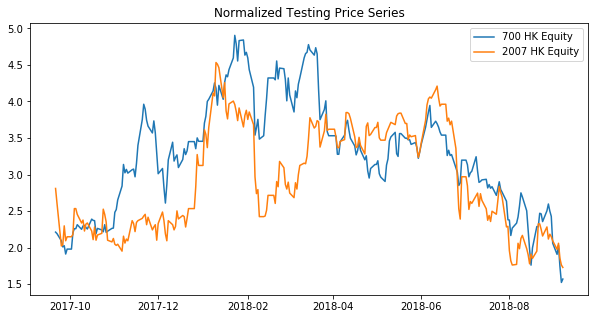

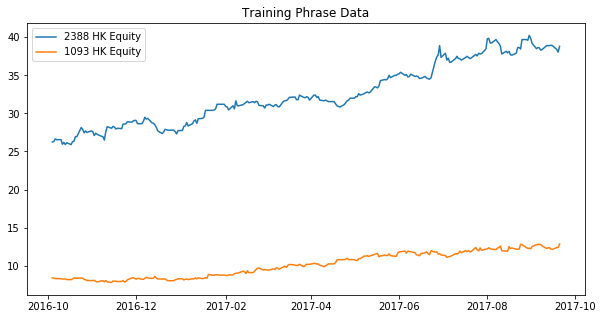

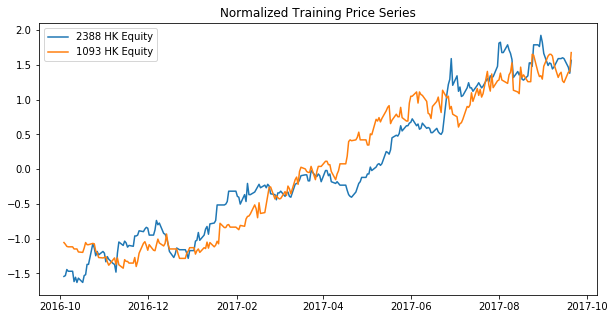

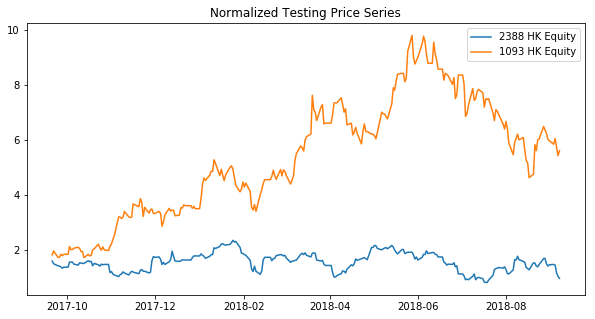

In [14]:
result = pair_selector.distance(train_df, test_df, 10)

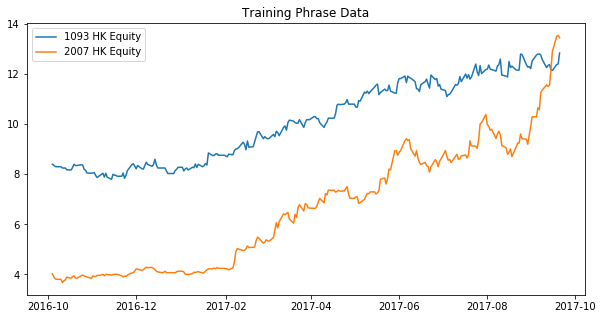

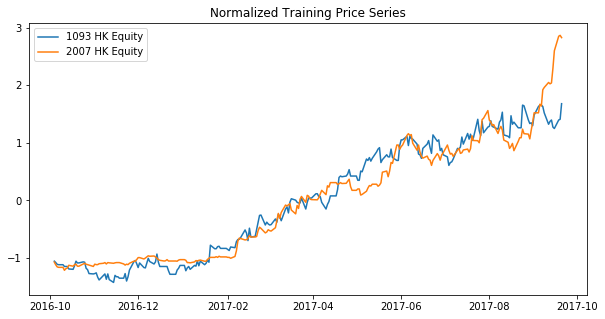

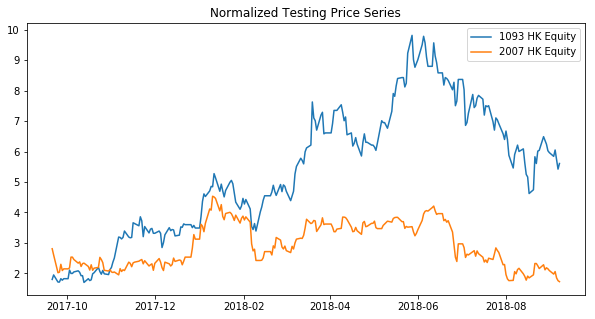

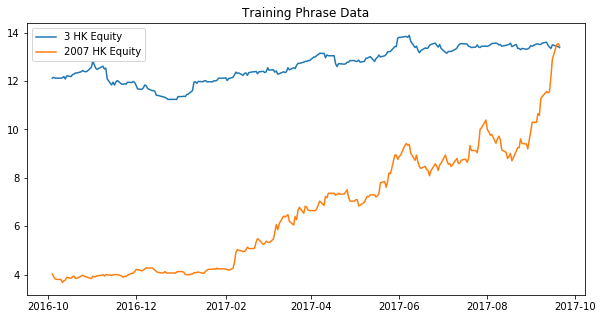

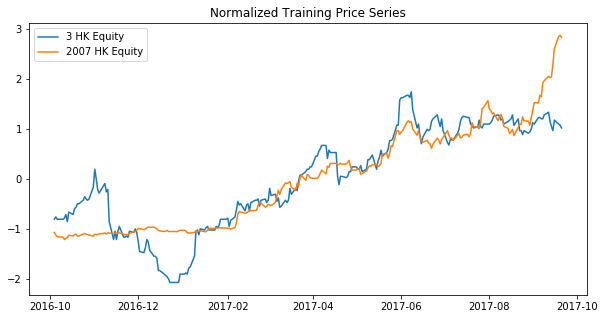

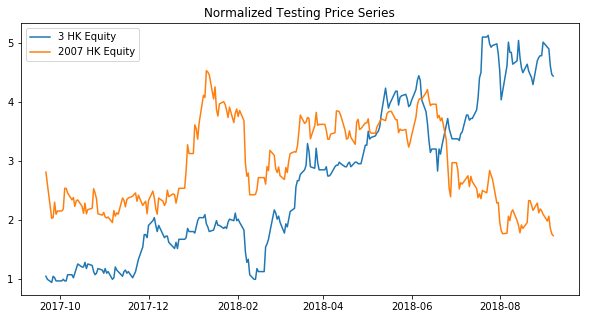

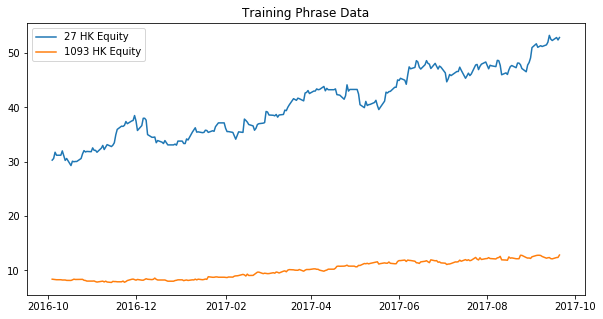

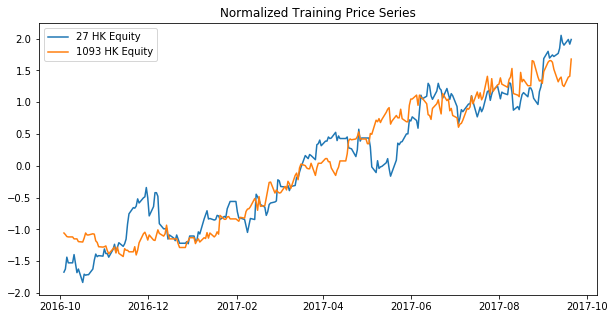

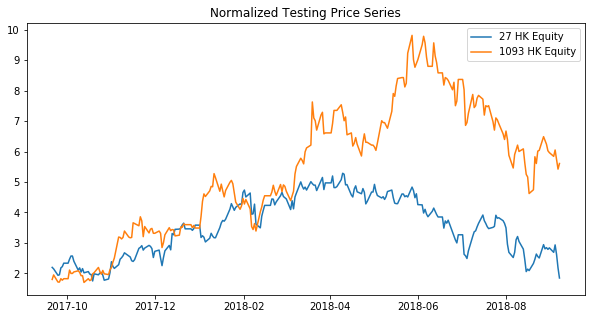

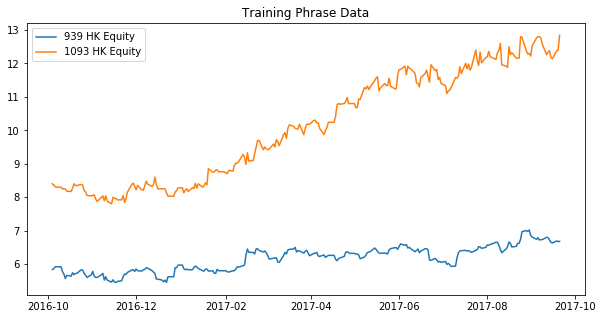

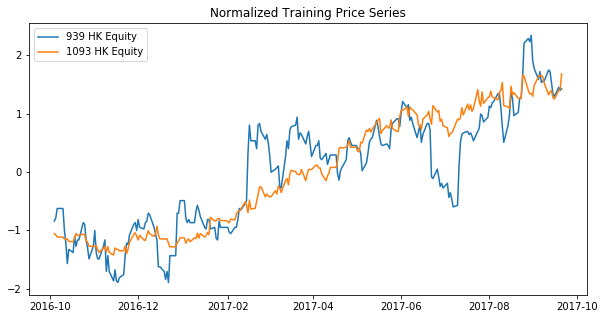

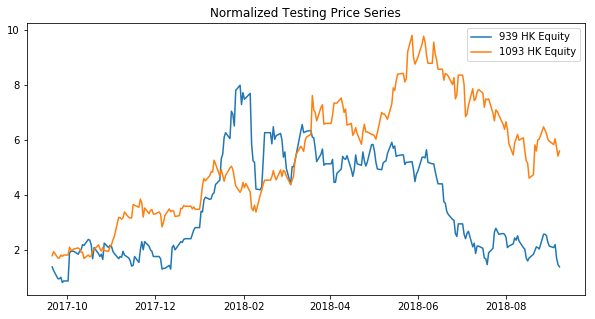

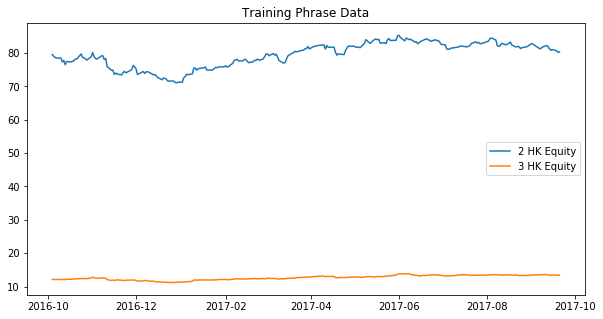

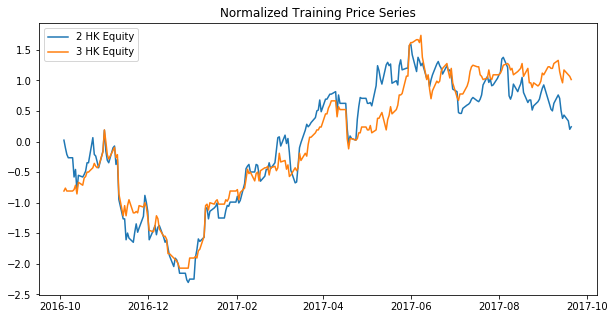

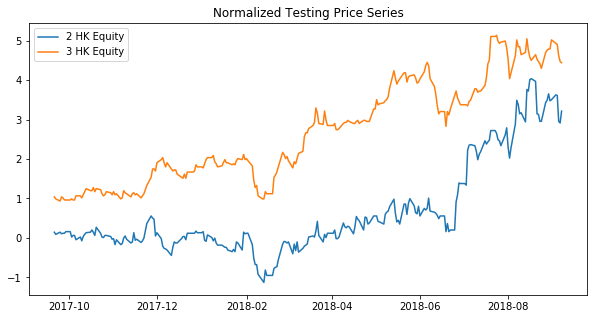

updatedddddd


[('1093 HK Equity', '2007 HK Equity'),
 ('3 HK Equity', '2007 HK Equity'),
 ('27 HK Equity', '1093 HK Equity'),
 ('939 HK Equity', '1093 HK Equity'),
 ('2 HK Equity', '3 HK Equity')]

In [13]:
pair_selector.intersection(train_df, test_df, 5)

### Log price

In [ ]:
data["valid_stocks_log"] = np.log(data["valid_stocks"])

### Correlation

In [ ]:
data["valid_stocks_log"].corr()

In [ ]:
def get_k_most_correlated_pairs(df, k):
    n_cols = len(df.columns.values.tolist())
    
    c = df.corr().abs()

    s = c.unstack()
    so = s.sort_values(kind="quicksort")

    return so[(-2*k) - n_cols:-n_cols]

get_k_most_correlated_pairs(data["valid_stocks_log"], 20)

In [ ]:
get_k_most_correlated_pairs(data["valid_stocks_log"][-training_size-buffer:-buffer], 20)

### Cointegration

In [ ]:
import pair_selector
from statsmodels.tsa.stattools import adfuller

buffer = 100
training_size = 500

cointegrated_pairs = pair_selector.coint(data["valid_stocks_log"], intercept=True, sig_level=0.005)

In [ ]:
for stock_pair in cointegrated_pairs:
    print("Checking pair: " + stock_pair[0] + ", " + stock_pair[1])

    plt.plot(data["valid_stocks_log"][stock_pair[0]][-training_size-buffer:-buffer])
    plt.plot(data["valid_stocks_log"][stock_pair[1]][-training_size-buffer:-buffer])
    plt.show()

    X = data["valid_stocks_log"][stock_pair[0]][-training_size-buffer:-buffer]
    Y = data["valid_stocks_log"][stock_pair[1]][-training_size-buffer:-buffer]

    # add intercept
    X = sm.add_constant(X)

    # Y = beta*X + C
    model = sm.OLS(Y, X)
    results = model.fit()
    
    print(results.params)

    plt.plot(results.resid)
    plt.show()


    ls = []

    for i in range(0, buffer):
        observed_x = data["valid_stocks_log"][stock_pair[0]][-buffer + i:][0]
        observed_y = data["valid_stocks_log"][stock_pair[1]][-buffer + i:][0]

        spread = (results.params[1] * observed_x + results.params[0]) - observed_y
        ls.append(spread)

    plt.plot(ls)
    plt.show()

    adfuller(ls)

In [ ]:
def get_cointegrated_triplets(df, sig_level = 0.001):
    cointegrated_triplets = []
    
    stock_names = df.columns.values.tolist()
    triplets = list(itertools.combinations(stock_names, 3))
    N = len(triplets)
    
    for triplet in triplets:
        stock_1, stock_2, stock_3 = triplet

        Y = df[stock_1]
        X = df[[stock_2, stock_3]]
        X = sm.add_constant(X)

        model = sm.OLS(Y, X)
        results = model.fit()

        p_value = adfuller(results.resid)[1]

        if p_value < sig_level:
            cointegrated_triplets.append(tuple([stock_1, stock_2, stock_3]))
            plt.plot(results.resid)
            plt.show()

    return cointegrated_triplets

cointegrated_triplets = get_cointegrated_triplets(data["valid_stocks_log"][-training_size-buffer:-buffer])